# Prepare single-cell data for bulk deconvolution of MAGNet cohort (PRJNA595151) using Scaden

Data from PRJNA595151 contain 366 samples (we are using 360, minus 6 PPCM). These are **left ventricle free-wall tissue samples** harvested at the time of cardiac surgery from subjects with heart failure undergoing transplantation and from unused donor hearts with apparently normal function.


## scRNA-seq and snRNA-seq data

See https://redmine.dieterichlab.org/projects/magenet/wiki/Deconvolution for details.

1. Wang et al. (2020) Nat. Cell Biology

2. Litvinukova et al. (2020) Nature https://www.heartcellatlas.org.

3. Tucker et al. (2020) Circulation https://singlecell.broadinstitute.org/single_cell/study/SCP498/transcriptional-and-cellular-diversity-of-the-human-heart#study-download.

4. See et al. (2017) Nat. Comm. **UNUSED**

5. Nomura et al. (2018) Nat. Comm. **UNUSED**

6. Selewa et al. (2020) Sci. Rep. **UNUSED**


### Processing

- Since the bulk data is from ventricular tissue, we need to remove all cells that are explicitely taken from atrial tissue, but we leave interventricular septum and left ventricular apex samples (Litvinukova).
- We also *match* assigned clusters to reported tissue sampling region, and discard any ambiguous association.
- We subset relevant cells only, and group together other cells. We also need to match *cell names* between studies.

For training and cross-validation, these dataset need to be further decomposed. This is not done here. 


### Notes

- Use all cells and genes (not only HVG), write normalized matrix in layer (we need to use this for input to Scaden, *c.f.* normalize your count data to library size ). In all cases, single-cell or bulk, the expression values should not be on a logarithmic scale.

- Preparation of bulk data done elsewhere. Your data can either be raw counts or normalized, just make sure that they are not in logarithmic space already.



In [2]:
import os

import anndata

import numpy as np
import pandas as pd
import scipy as sp
import scanpy as sc

import loompy as lp

import bbknn

import seaborn as sns
import matplotlib.pyplot as plt

In [51]:
from matplotlib import colors

# from Scrublet
def darken_cmap(cmap, scale_factor):
    cdat = np.zeros((cmap.N, 4))
    for ii in range(cdat.shape[0]):
        curcol = cmap(ii)
        cdat[ii,0] = curcol[0] * scale_factor
        cdat[ii,1] = curcol[1] * scale_factor
        cdat[ii,2] = curcol[2] * scale_factor
        cdat[ii,3] = 1
    cmap = cmap.from_list(cmap.N, cdat)
    return cmap
cmaps = darken_cmap(plt.cm.Reds, 0.9)

In [3]:
sc.settings.set_figure_params(dpi=100, facecolor='white', frameon=False)

In [95]:
# data

scDir = '/prj/LZ_PR2B_rewiring'

# GSE109816: processed data UMI matrices and metadata split into multiple files
# HCA_Heart: processed data h5ad
# SCP498: processed data, use the h5ad V4, separate MTX UMI matrix and metadata are under 
# expression/5d544a83328cee364c3cfce9/gene_sorted-matrix.mtx, and metadata/meta.data.v3.txt

dirs = {
    'Wang': os.path.join(scDir, 'public', 'GSE109816'),
    'Litvinukova': os.path.join(scDir, 'public', 'HCA_Heart'),
    'Tucker': os.path.join(scDir, 'public', 'SCP498', 'other')
}
dataf = {
    'Wang': {'GSE109816': {'barcodes': 'GSE109816_metadata_barcodes_9994cells.txt.gz', 
                           'clusters': 'GSE109816_normal_heart_cell_cluster_info.txt.gz', 
                           'mtx': 'GSE109816_normal_heart_umi_matrix.csv.gz'},
             'GSE121893': {'barcodes': 'GSE121893_human_heart_sc_info.txt.gz', 
                           'clusters': 'GSE121893_all_heart_cell_cluster_info.txt.gz', 
                           'mtx': 'GSE121893_human_heart_sc_umi.csv.gz'}},
    'Litvinukova': 'global_raw.h5ad',
    'Tucker': 'healthy_human_4chamber_map_unnormalized_V4.h5ad'
}

outputDir = '/prj/MAGE/analysis/deconvolution/scdata/scaden'


anndd = {}

## Wang

We need to combine both studies, and this is messy... 

#### GSE109816

The UMI matrix contains 9,994 cells (all normal heart). The metadata contains the 7,495 cells, but not all these cells are contained in the UMI matrix, *i.e.* we need to combined both studies.

#### GSE121893

If we merge the cluster info from both studies (7,495 + 11,377), we end up with 11,716 cells (including the 7,495 cells from normal hearts), but the UMI matrix is specific to GSE121893 (4,933 cells). BUT the problem is that cluster assignment (cell types) are recorded in the 2 cluster info files (and in the CellType field in the metadata for GSE121893) and differ for a large number of normal samples ( *e.g.* SC_92563_4_41 is both SMC and EC ). It is unclear where this stems from, but may be related to re-analysis of normal samples after including the HF samples...?? Here we need to make a choice, unless we want to re-analyze the data, or drop these cells. Besides, many CM cell types are assigned to the wrong source *e.g.* cluster cell type assigned to CM LV while tissue sample is from LA. Here, we just re-assign based on the tissue source.


There are also some missing cells, we have a total of 10,706 cells only (14,927 cells in total, healthy and hearth failure patients), and we end up with 7,443 cells for the normal hearts, *c.f.* what is said in the paper "[...] we collected a total of 12,266 single cells from 14 healthy donors using a single-cell platform that enables visual inspection and selection of individual live cells. Of these cells, 7,495 passed stringent quality control [...]". 



In [5]:
data_key = 'Wang'
study_key = 'GSE109816'

wang_meta1 = pd.read_csv(os.path.join(dirs[data_key], dataf[data_key][study_key]['barcodes']), 
                         sep='\t')

# adjust format to match that of second table
# in all cases, we standardize the names in the output
cols = {'Sample name (9994 single cells)':'CellID',
        'characteristics: individual':'Individual',
        'characteristics: age':'Age',
        'characteristics: gender':'Gender'
       }
wang_meta1.rename(columns=cols, inplace=True)
drop = ['organism',
        'molecule',
        'molecule',
        'SRR run accession',
        'raw file (original file name)',
        'raw file (original file name).1',
        'Dispense.Order',
        'X384.Well.Plate.Location',
        'Chip.Row.ID',
        'Chip.Column.ID',
        'Image.ID'
       ]
wang_meta1.drop(drop, inplace=True, axis=1)

wang_clust1 = pd.read_csv(os.path.join(dirs[data_key], dataf[data_key][study_key]['clusters']), 
                          sep='\t')
wang_clust1.rename(columns={'ID': 'CellID', 
                            'CellType': 'ClusterID'}, inplace=True)
drop = ['Cluster_ID']
wang_clust1.drop(drop, inplace=True, axis=1)
wang_clust1['Condition'] = wang_clust1['Condition'].apply(lambda x: f"N_{x}")

wang_mat1 = pd.read_csv(os.path.join(dirs[data_key], dataf[data_key][study_key]['mtx']), 
                        sep=',',
                        index_col=0)


print("Metadata")
msg = f"CellID:{len(wang_meta1.CellID.unique())}" # Barcode != CellID ?!?
print(msg)
msg = f"Type:{wang_meta1.Type.unique()}"
print(msg)
msg = f"Individual:{wang_meta1.Individual.unique()}" 
print(msg)

print("Clusters")
msg = f"CellID:{len(wang_clust1.CellID.unique())}" 
print(msg)
msg = f"ClusterID:{wang_clust1.ClusterID.unique()}"
print(msg)
msg = f"Condition:{wang_clust1.Condition.unique()}"
print(msg)
msg = f"Group:{wang_clust1.Group.unique()}" 
print(msg)

print(f"MTX_{wang_mat1.shape}")


Metadata
CellID:9994
Type:['N_LA_NCM' 'N_LA_CM' 'N_LV_CM' 'N_LV_NCM']
Individual:['N6' 'N9' 'N8' 'N11' 'N7' 'N10' 'N3' 'N2' 'N5' 'N4' 'N12' 'N1']
Clusters
CellID:7495
ClusterID:['EC' 'MP' 'SMC' 'FB' 'CM']
Condition:['N_LA' 'N_LV']
Group:['NCM' 'CM']
MTX_(54750, 9994)


In [6]:
data_key = 'Wang'
study_key = 'GSE121893'

wang_meta2 = pd.read_csv(os.path.join(dirs[data_key], dataf[data_key][study_key]['barcodes']), 
                         sep='\t',
                         skiprows=15)
# adjust format to match that of first table
# in all cases, we standardize the names in the output
cols = {'ID':'CellID'}
wang_meta2.rename(columns=cols, inplace=True)
drop = ['Dispense.Order',
        'X384.Well.Plate.Location',
        'Chip.Row.ID',
        'Chip.Column.ID',
        'Image.ID'
       ]
wang_meta2.drop(drop, inplace=True, axis=1)

wang_clust2 = pd.read_csv(os.path.join(dirs[data_key], dataf[data_key][study_key]['clusters']), 
                          sep='\t')
wang_clust2.rename(columns={'ID': 'CellID', 
                            'condition': 'Condition',
                            'group': 'Group'}, inplace=True)
# drop sub-clusters
wang_clust2['ClusterID'] = wang_clust2.ident.str.replace('\d+', '')
drop = ['sample', 'ident', 'Age'] # hopefully these fields match the overall metadata (or cluster info form file 1)...
wang_clust2.drop(drop, inplace=True, axis=1)

# now combine all clusters...
# see above re cluster assignment, we use the second file, where CMs are split into LV, LA, and AV 
cols = ['CellID', 'nGene', 'nUMI', 'Condition', 'Group', 'ClusterID']
PASS = pd.merge(wang_clust1[cols], wang_clust2[cols], on=cols, how='outer')
cols = ['CellID', 'nGene', 'nUMI', 'Condition', 'Group']
PASS.drop_duplicates(subset=cols, keep='last', inplace=True)

# if we pick only the normal samples, we should get back the previous set of 7,495 cells.
print(f"Normal: {len(PASS[PASS.Condition.str.startswith('N')].CellID.unique())}")


wang_mat2 = pd.read_csv(os.path.join(dirs[data_key], dataf[data_key][study_key]['mtx']), 
                        sep=',',
                        index_col=0)


print("Metadata")
msg = f"CellID:{len(wang_meta2.CellID.unique())}" # Barcode != CellID ?!?
print(msg)
msg = f"Type:{wang_meta2.Type.unique()}"
print(msg)
msg = f"Individual:{wang_meta2.Individual.unique()}" 
print(msg)

print("Clusters")
msg = f"CellID:{len(wang_clust2.CellID.unique())}" 
print(msg)
msg = f"CellID (PASS):{len(PASS.CellID.unique())}" 
print(msg)
msg = f"ClusterID:{wang_clust2.ClusterID.unique()}"
print(msg)
msg = f"Condition:{wang_clust2.Condition.unique()}"
print(msg)
msg = f"Group:{wang_clust2.Group.unique()}" 
print(msg)

print(f"MTX_{wang_mat2.shape}")

<ipython-input-6-9aa643efd7c1>:25: FutureWarning: The default value of regex will change from True to False in a future version.
  wang_clust2['ClusterID'] = wang_clust2.ident.str.replace('\d+', '')


Normal: 7495
Metadata
CellID:4933
Type:['HF_LA_CM' 'HF_LV_NCM' 'HF_LA_NCM' 'HF_LV_CM' 'N_LA_CM' 'N_LV_CM'
 'N_LV_NCM' 'N_LA_NCM']
Individual:['C1' 'D1' 'C2' 'D2' 'D5' 'D4' 'N13' 'N14']
Clusters
CellID:11377
CellID (PASS):11716
ClusterID:['EC' 'SMC' 'FB' 'MP' 'LV' 'AV' 'LA']
Condition:['N_LA' 'cHF_LV' 'cHF_LA' 'dHF_LV' 'dHF_LA' 'N_LV']
Group:['NCM' 'CM']
MTX_(25742, 4933)


In [7]:
# now actually merge everything
CLUSTERS = pd.merge(pd.concat([wang_meta1, wang_meta2]), PASS, on='CellID', how='right')

# remove the missing cells - we have metadata, but these are not in the UMI matrices 
CLUSTERS['Source1'] = CLUSTERS.Type.apply(lambda x: x.split('_')[1] if isinstance(x, str) else np.NaN)
CLUSTERS['Source2'] = CLUSTERS.Condition.apply(lambda x: x.split('_')[1] if isinstance(x, str) else np.NaN)
m = np.where(CLUSTERS['Source1'] == CLUSTERS['Source2'], True, False)
CLUSTERS = CLUSTERS[m]

# assume source name is correct, and assign unique source, then 
# re-assign CM (or LA, LV, AV) to either LA or LV based on the tissue source
CLUSTERS.rename(columns={'Source1':'Source'}, inplace=True)
# also drop these 'source name', 'CellType'
CLUSTERS.drop(['Source2', 'source name', 'CellType'], inplace=True, axis=1)

def check_assignment(row):
    
#     ret = False
#     cid = row.ClusterID
#     if cid in ['LA', 'LV']:
#         if cid == row.Source:
#             ret = True
#     return ret # just here, at least 900 cells are wrongly classified...
    
    cid = row.ClusterID
    if cid in ['CM', 'LV', 'AV', 'LA']:
        cid = row.Source
    else:
        pass
    return cid

CLUSTERS['ClusterID'] = CLUSTERS.apply(check_assignment, axis=1)

# now remove atrial cells - i.e. everythin that was sampled from atria
CLUSTERS = CLUSTERS[CLUSTERS['Source']=='LV']

# counts
df = wang_mat1.join(wang_mat2)
df.fillna(0, inplace=True)
df = df[CLUSTERS.CellID]

# transpose
X = sp.sparse.csr_matrix(df.values.T)
# use columns/cells as obs
obs = pd.DataFrame(df.columns)
obs.rename(columns={0:'CellID'}, inplace=True)
obs = obs.merge(CLUSTERS, on='CellID')
obs.set_index('CellID', drop=True, inplace=True, verify_integrity=True)
obs.index.name = None 
# use rows/genes as var
var = pd.DataFrame(df.index)
var.set_index(0, drop=True, inplace=True, verify_integrity=True)
# generate AnnData
adata = anndata.AnnData(X,
                        obs=obs,
                        var=var)

# adata.var_names.name = 'gene_ids'
adata.var.index.name = None
adata.var_names_make_unique()

# select cells based on the published results - DONE
# adata = adata[adata.obs.index.isin(CLUSTERS.CellID), :]

# restrict to gene set from GSE121893
adata = adata[:, adata.var_names.isin(wang_mat2.index)]
adata

View of AnnData object with n_obs × n_vars = 4938 × 25742
    obs: 'Individual', 'Age', 'Gender', 'Barcode', 'Type', 'Barcode.Read.Pairs', 'Distinct.UMIs', 'ERCC.Read.Pairs', 'Trimmed.Read.Pairs', 'NoContam.Read.Pairs', 'Mitochondria.Alignments', 'Mitochondria.Read.Pairs', 'Total.Barcode.Alignments', 'Distinct.Genes.w..Alignments', 'Distinct.Gene.UMI.Combos', 'Aligned', 'Assigned', 'Ambiguity', 'Chimera', 'Duplicate', 'FragementLength', 'MappingQuality', 'MultiMapping', 'NoFeatures', 'Nonjunction', 'Secondary', 'Unmapped', 'mito.perc', 'nGene', 'nUMI', 'Condition', 'Group', 'ClusterID', 'Source'

In [94]:
# save tmp
# adata.write(os.path.join(outputDir, f"{data_key}_tmp.h5ad"))

In [ ]:
# we go through the standard workflow to check if the cell types make sense

In [10]:
adata_copy = adata.copy()
adata_copy.obs['n_counts'] = adata_copy.X.sum(1)
sc.pp.normalize_total(adata_copy, target_sum=1e4, exclude_highly_expressed=True)
sc.pp.log1p(adata_copy)
adata_copy.raw = adata_copy
sc.pp.combat(adata_copy, key='Individual')
sc.pp.highly_variable_genes(adata_copy) 
sc.pp.regress_out(adata_copy, ['n_counts']) # or nUMIs
sc.tl.pca(adata_copy, svd_solver='arpack', use_highly_variable=True)
# sc.pl.pca_variance_ratio(adata_copy, log=True)
n_pcs = 10

Found 11 genes with zero variance.


/home/eboileau/.virtualenvs/sc3.9/lib/python3.9/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: invalid value encountered in true_divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()
/home/eboileau/.virtualenvs/sc3.9/lib/python3.9/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: divide by zero encountered in true_divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


In [23]:
# replace neighbors with bbknn
# defaults approx=True, metric='angular', trim=None, n_trees=10 (with approx=True)
# default n_neighbors : 15, here we have 13 individuals, so we're using total number of neighbours = 26
adata_bbknn = bbknn.bbknn(adata_copy, batch_key='Individual', neighbors_within_batch=1, n_pcs=n_pcs, trim=None, copy=True) 
# clustering is done already, else apply leiden here
bbknn.ridge_regression(adata_bbknn, batch_key=['Individual'], confounder_key=['ClusterID'])
sc.tl.pca(adata_bbknn, 
          svd_solver='arpack', 
          use_highly_variable=True)
bbknn.bbknn(adata_bbknn, batch_key='Individual', neighbors_within_batch=1, n_pcs=n_pcs, trim=None)
sc.tl.umap(adata_bbknn)

In [31]:
sc.tl.tsne(adata_bbknn, use_fast_tsne=False, n_pcs=n_pcs)

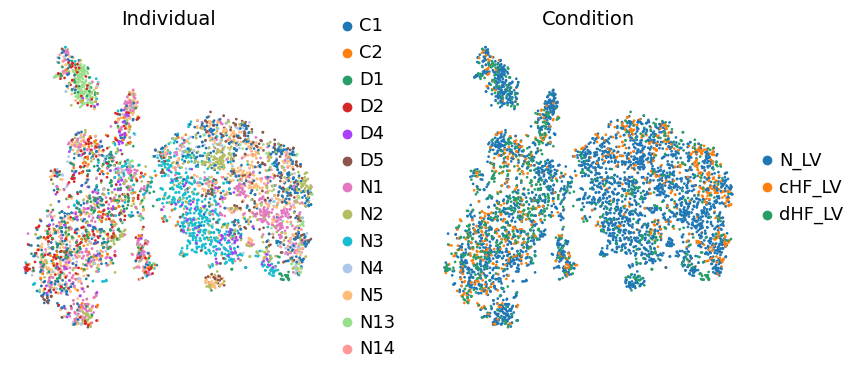

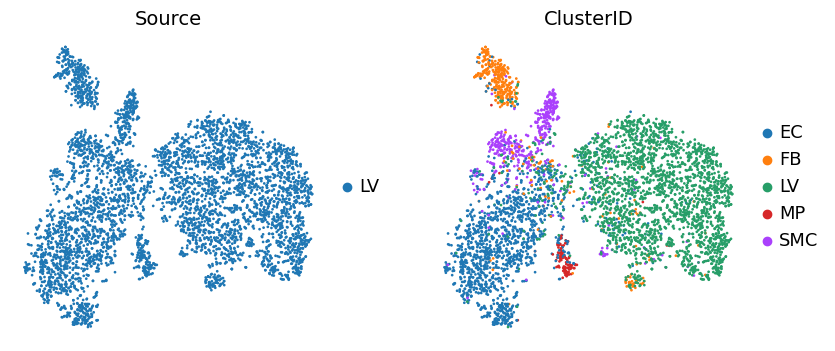

In [32]:
sc.pl.tsne(adata_bbknn, color=['Individual', 'Condition'], size=75000/adata.shape[0])
sc.pl.tsne(adata_bbknn, color=['Source', 'ClusterID'], size=75000/adata.shape[0])

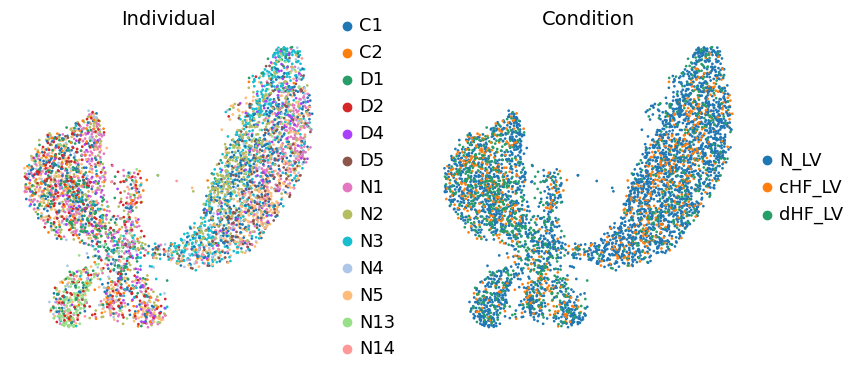

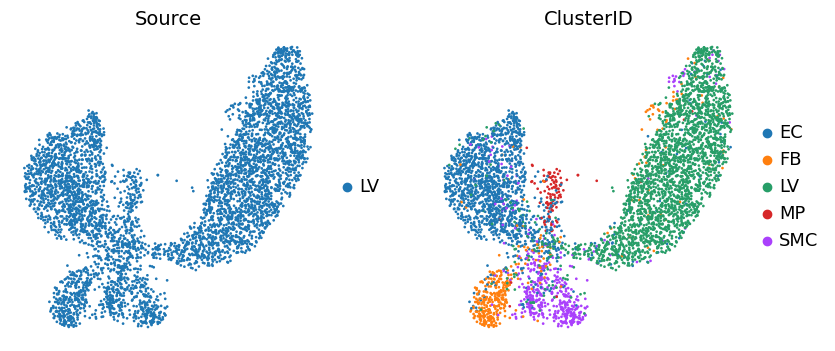

In [27]:
sc.pl.umap(adata_bbknn, color=['Individual', 'Condition'], size=75000/adata.shape[0])
sc.pl.umap(adata_bbknn, color=['Source', 'ClusterID'], size=75000/adata.shape[0])

In [30]:
adata_bbknn.obs['ClusterID'].value_counts()

LV     2450
EC     1524
SMC     467
FB      390
MP      107
Name: ClusterID, dtype: int64

In [15]:
# or neighbours
adata_neig = adata_copy.copy()
sc.pp.neighbors(adata_neig, n_pcs=n_pcs)
sc.tl.umap(adata_neig)

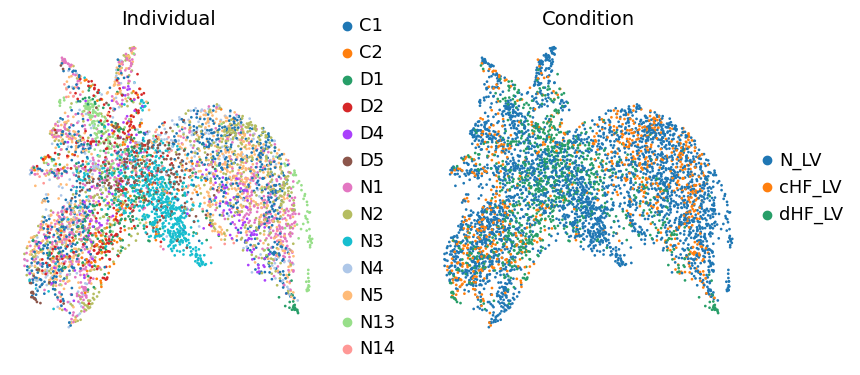

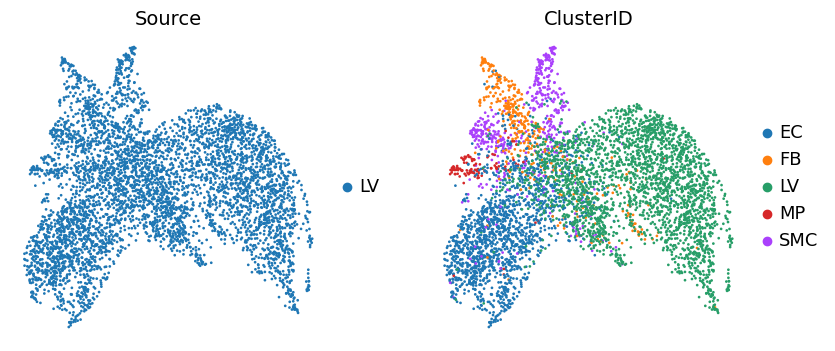

In [33]:
sc.pl.umap(adata_neig, color=['Individual', 'Condition'], size=75000/adata.shape[0])
sc.pl.umap(adata_neig, color=['Source', 'ClusterID'], size=75000/adata.shape[0])

In [35]:
# marker genes from the paper (Supp. Table 2, 4)
# compare with the published results

df = pd.read_csv(os.path.join(dirs[data_key], '41556_2019_446_MOESM3_ESM.csv'), skiprows=1)
markers = dict()
for cluster in df.cluster.unique():
    markers[cluster] = df[df.cluster==cluster].gene.values
    
df = pd.read_csv(os.path.join(dirs[data_key], '41556_2019_446_MOESM4_ESM.csv'))
markers_cm = dict()
for cluster in df.cluster.unique():
    markers_cm[cluster] = df[df.cluster==cluster].gene.values

markers_all = {**markers , **markers_cm}

In [39]:
sc.tl.rank_genes_groups(adata_bbknn, groupby='ClusterID', 
                        key_added='ranked_ClusterID', 
                        method='wilcoxon', tie_correct=True)

/home/eboileau/.virtualenvs/sc3.9/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:323: RuntimeWarning: invalid value encountered in true_divide
  scores[group_index, :] = (


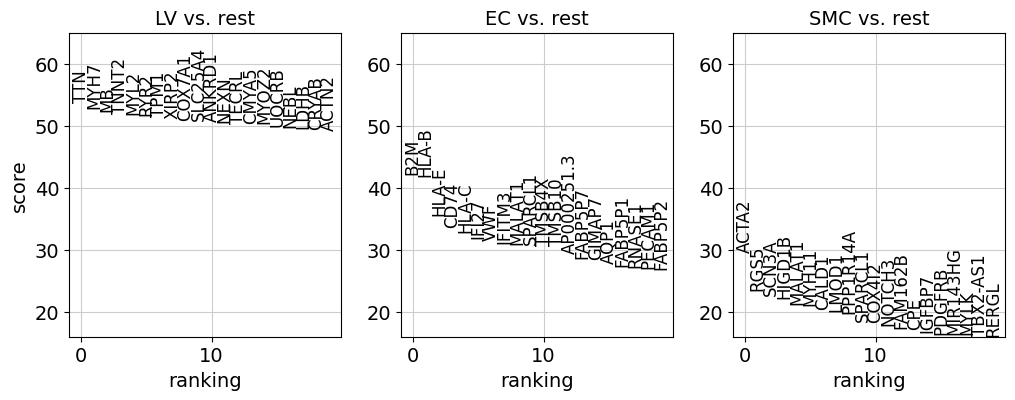

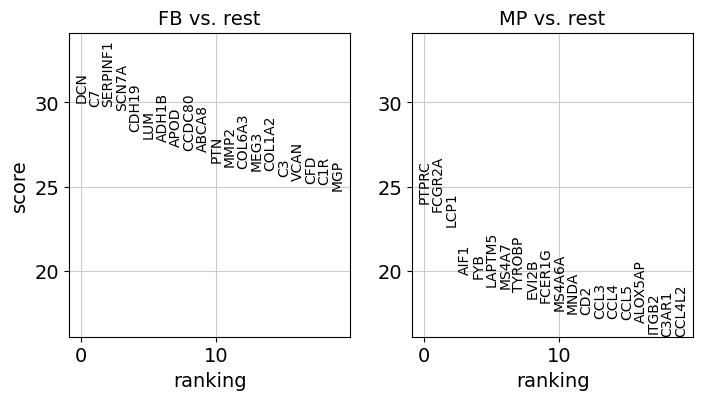

In [40]:
# plot marker genes
sc.pl.rank_genes_groups(adata_bbknn, key='ranked_ClusterID', groups=['LV','EC','SMC'], fontsize=12)
sc.pl.rank_genes_groups(adata_bbknn, key='ranked_ClusterID', groups=['FB','MP'], fontsize=10)

<AxesSubplot:>

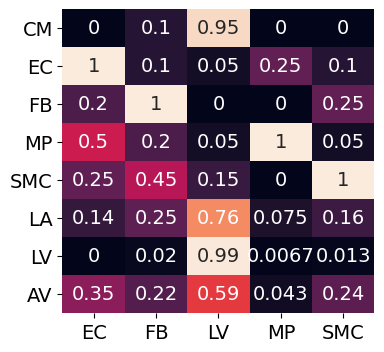

In [41]:
cell_annotation_norm = sc.tl.marker_gene_overlap(adata_bbknn, markers_all, key='ranked_ClusterID', 
                                                 normalize='reference', adj_pval_threshold=1e-6)
sns.heatmap(cell_annotation_norm, cbar=False, annot=True)

In [48]:
ids = np.in1d(adata_bbknn.var_names, markers_all['CM'])
adata_bbknn.obs['CM_markers_expr'] = adata_bbknn.raw.X[:,ids].mean(1)

ids = np.in1d(adata_bbknn.var_names, markers_all['LV'])
adata_bbknn.obs['LV_markers_expr'] = adata_bbknn.raw.X[:,ids].mean(1)

ids = np.in1d(adata_bbknn.var_names, markers_all['LA'])
adata_bbknn.obs['LA_markers_expr'] = adata_bbknn.raw.X[:,ids].mean(1)

ids = np.in1d(adata_bbknn.var_names, markers_all['AV'])
adata_bbknn.obs['AV_markers_expr'] = adata_bbknn.raw.X[:,ids].mean(1)

ids = np.in1d(adata_bbknn.var_names, markers_all['EC'])
adata_bbknn.obs['EC_markers_expr'] = adata_bbknn.raw.X[:,ids].mean(1)

ids = np.in1d(adata_bbknn.var_names, markers_all['FB'])
adata_bbknn.obs['FB_markers_expr'] = adata_bbknn.raw.X[:,ids].mean(1)

ids = np.in1d(adata_bbknn.var_names, markers_all['SMC'])
adata_bbknn.obs['SMC_markers_expr'] = adata_bbknn.raw.X[:,ids].mean(1)

ids = np.in1d(adata_bbknn.var_names, markers_all['MP'])
adata_bbknn.obs['MP_markers_expr'] = adata_bbknn.raw.X[:,ids].mean(1)

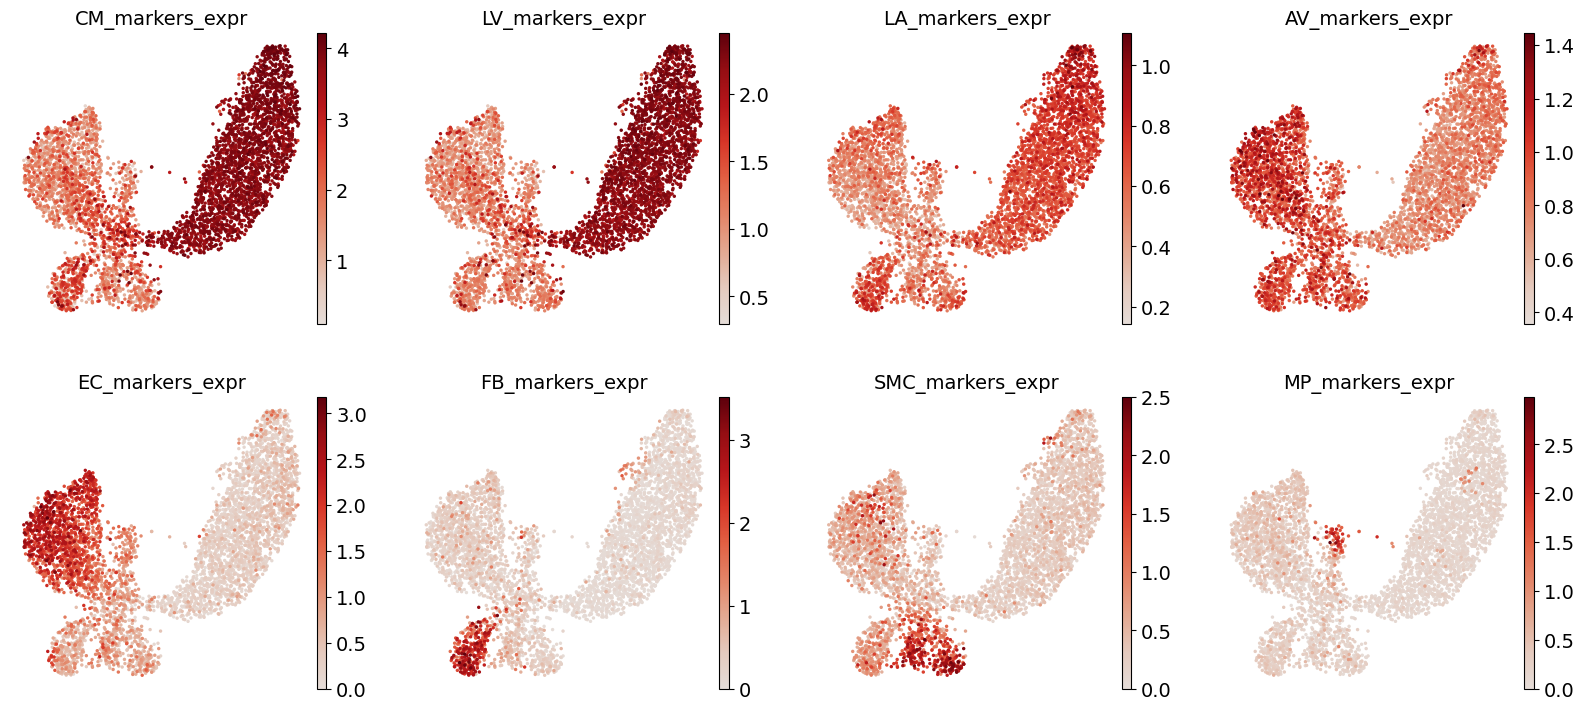

In [52]:
sc.pl.umap(adata_bbknn, color=['CM_markers_expr', 'LV_markers_expr', 'LA_markers_expr', 'AV_markers_expr', 
                               'EC_markers_expr', 'FB_markers_expr', 'SMC_markers_expr', 'MP_markers_expr'], 
           ncols=4, color_map=cmaps)

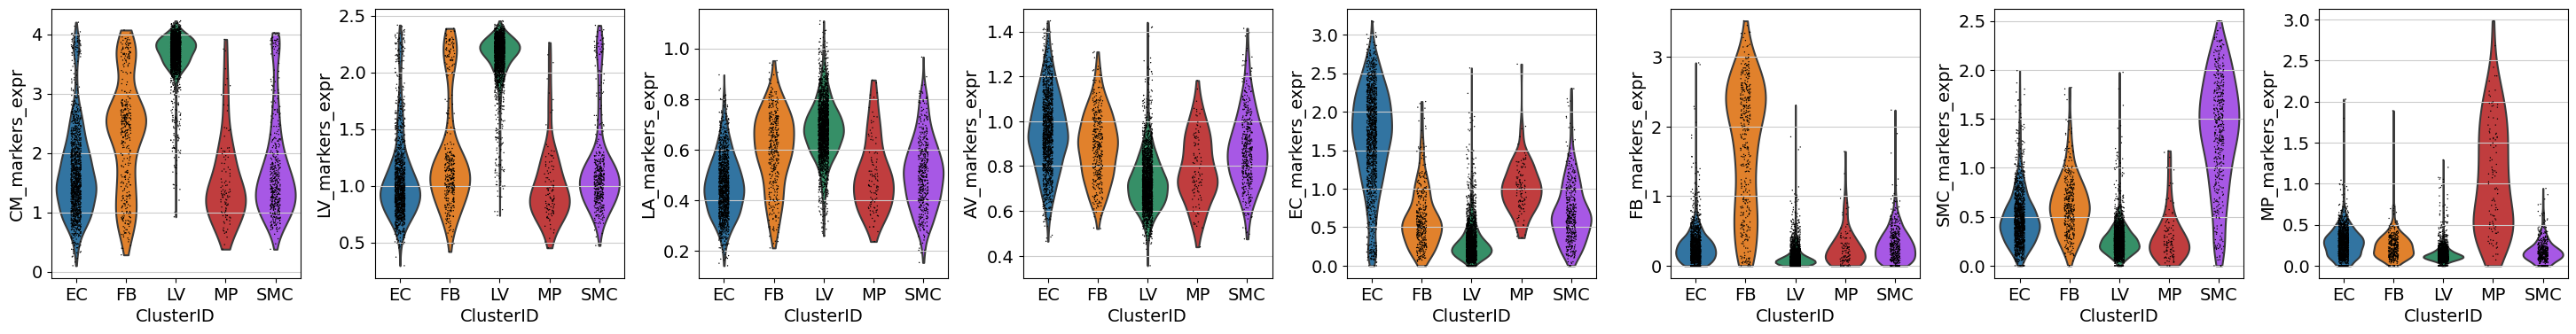

In [53]:
sc.pl.violin(adata_bbknn, ['CM_markers_expr', 'LV_markers_expr', 'LA_markers_expr', 'AV_markers_expr', 
                    'EC_markers_expr', 'FB_markers_expr', 'SMC_markers_expr', 'MP_markers_expr'], groupby='ClusterID')

In [54]:
adata

AnnData object with n_obs × n_vars = 4938 × 25742
    obs: 'Individual', 'Age', 'Gender', 'Barcode', 'Type', 'Barcode.Read.Pairs', 'Distinct.UMIs', 'ERCC.Read.Pairs', 'Trimmed.Read.Pairs', 'NoContam.Read.Pairs', 'Mitochondria.Alignments', 'Mitochondria.Read.Pairs', 'Total.Barcode.Alignments', 'Distinct.Genes.w..Alignments', 'Distinct.Gene.UMI.Combos', 'Aligned', 'Assigned', 'Ambiguity', 'Chimera', 'Duplicate', 'FragementLength', 'MappingQuality', 'MultiMapping', 'NoFeatures', 'Nonjunction', 'Secondary', 'Unmapped', 'mito.perc', 'nGene', 'nUMI', 'Condition', 'Group', 'ClusterID', 'Source'

In [97]:
# I think that's about the best we could do...
# rename the cell types, clean obs
# we still need to add genes ids - we do that after processing all input files

adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['n_genes'] = (adata.X > 0).sum(1)

to_keep = ['Individual', 'Age', 'Gender', 'Condition', 'n_counts', 'n_genes', 'Source', 'ClusterID']
adata.obs = adata.obs[to_keep]

cats = ['Ventricular_cardiomyocyte',
        'Endothelial',
        'Smooth_muscle',
        'Immune',
        'Fibroblast']
adata.obs['ClusterID'] = adata.obs['ClusterID'].cat.add_categories(cats)
adata.obs.loc[adata.obs['ClusterID']=='LV', 'ClusterID'] = 'Ventricular_cardiomyocyte'
adata.obs.loc[adata.obs['ClusterID']=='EC', 'ClusterID'] = 'Endothelial'
adata.obs.loc[adata.obs['ClusterID']=='FB', 'ClusterID'] = 'Fibroblast'
adata.obs.loc[adata.obs['ClusterID']=='SMC', 'ClusterID'] = 'Smooth_muscle'
adata.obs.loc[adata.obs['ClusterID']=='MP', 'ClusterID'] = 'Immune'
adata.obs['ClusterID'] = adata.obs['ClusterID'].cat.remove_unused_categories()

anndd[data_key] = adata
anndd[data_key]

AnnData object with n_obs × n_vars = 4938 × 25742
    obs: 'Individual', 'Age', 'Gender', 'Condition', 'n_counts', 'n_genes', 'Source', 'ClusterID'

## Litvinukova

In [108]:
data_key = 'Litvinukova'

adata = sc.read_h5ad(os.path.join(dirs[data_key], dataf[data_key]))

adata.obs.index.name = None
adata.var.index.name = None

# not sure what this is... but in any case
adata = adata[adata.obs.Used=='Yes', :]

# remove some vars
to_keep = [l for l in adata.var if 'gene_ids' in l]
adata.var = adata.var[to_keep]
# assign ids, use Sanger-Cells, check if they are all equivalent?
adata.var['Accession'] = adata.var['gene_ids-Sanger-Cells']
# there are some undefined characters in cell_states causing an UnicodeDecodeError
adata.obs = adata.obs[[l for l in adata.obs if l != 'cell_states']]

# rename
adata.obs = adata.obs.rename(columns={'donor': 'Individual', 'gender': 'Gender', 'age_group': 'Age',
                                      'cell_type': 'ClusterID', 'region': 'Source', 'cell_source': 'Library', 'sample': 'Sample'})

# we remove unassigned cells, doublets
cells = ['NotAssigned', 'doublets']
adata = adata[~adata.obs.ClusterID.isin(cells), :]
# now remove everything that was taken from atria or right chambers, but keep septum and apex (left ventricular)
adata = adata[adata.obs.Source.isin(['AX', 'LV', 'SP']), :]
# clean
to_keep = ['Individual', 'Age', 'Gender', 'Sample', 'n_counts', 'n_genes', 'Library', 'Source', 'ClusterID']
adata.obs = adata.obs[to_keep]

# rename
cats = ['Ventricular_cardiomyocyte',
        'Smooth_muscle',
        'Pericyte',
        'Immune',
        'Other']    
adata.obs['ClusterID'] = adata.obs['ClusterID'].cat.add_categories(cats)
adata.obs.loc[adata.obs['ClusterID']=='Ventricular_Cardiomyocyte', 'ClusterID'] = 'Ventricular_cardiomyocyte'
adata.obs.loc[adata.obs['ClusterID']=='Pericytes', 'ClusterID'] = 'Pericyte'
adata.obs.loc[adata.obs['ClusterID']=='Smooth_muscle_cells', 'ClusterID'] = 'Smooth_muscle'
adata.obs.loc[adata.obs['ClusterID'].isin(['Lymphoid', 'Myeloid']), 'ClusterID'] = 'Immune'
adata.obs.loc[adata.obs['ClusterID'].isin(['Adipocytes', 'Mesothelial', 'Neuronal']), 'ClusterID'] = 'Other'
adata.obs['ClusterID'] = adata.obs['ClusterID'].cat.remove_unused_categories()

adata.obs['ClusterID'].value_counts()

Ventricular_cardiomyocyte    94374
Endothelial                  62914
Pericyte                     48322
Fibroblast                   28345
Immune                       20588
Smooth_muscle                 8892
Other                         2808
Name: ClusterID, dtype: int64

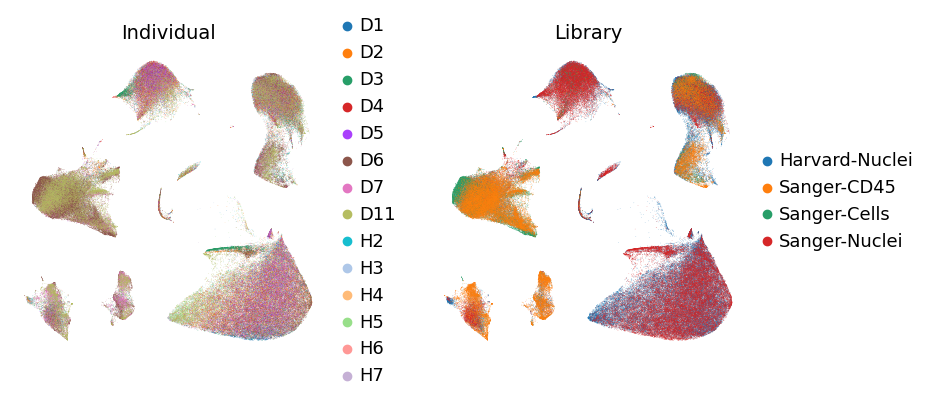

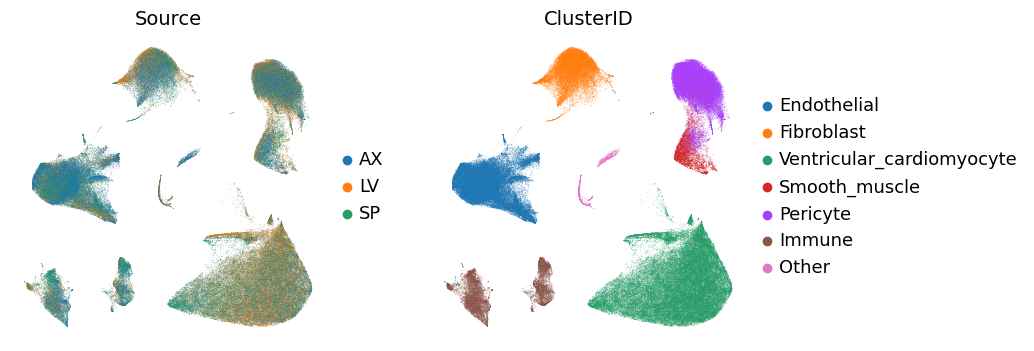

In [110]:
sc.pl.umap(adata, color=['Individual', 'Library'])
sc.pl.umap(adata, color=['Source', 'ClusterID'])

In [112]:
del adata.uns
del adata.obsm

In [115]:
anndd[data_key] = adata
anndd[data_key]

AnnData object with n_obs × n_vars = 266243 × 33538
    obs: 'Individual', 'Age', 'Gender', 'Sample', 'n_counts', 'n_genes', 'Library', 'Source', 'ClusterID'
    var: 'gene_ids-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'gene_ids-Sanger-CD45', 'Accession'

## Tucker

In [125]:
data_key = 'Tucker'

adata = sc.read_h5ad(os.path.join(dirs[data_key], dataf[data_key]))

adata.obs.index.name = None
adata.var.index.name = None


# rename
adata.obs = adata.obs.rename(columns={'biological.individual': 'Individual', 'chamber': 'Source',
                                      'Cluster': 'ClusterID', 'nUMI': 'n_counts', 'nGene': 'n_genes', 'experiment': 'Experiment'})

adata.var = adata.var.rename(columns={'gene_ids': 'Accession'})

# now remove everything that was taken from atria or right chambers
adata = adata[adata.obs.Source=='LV', :]
# the lysis of cells for single nuclear isolation produces significant cytoplasmic RNA
# contamination in the form of ambient RNA, these were identified as 'cytoplasmic'

# we also found afterwards that even if we keep LV, 86 cells are assigned to 03. Atrial Cardiomyocyte
# we either rename them, or just discard them

cells = ['05. Cytoplasmic Cardiomyocyte I', '12. Cytoplasmic Cardiomyocyte II', '03. Atrial Cardiomyocyte']
adata = adata[~adata.obs.ClusterID.isin(cells), :]

# clean
to_keep = ['Individual', 'n_counts', 'n_genes', 'Experiment', 'Source', 'ClusterID']
adata.obs = adata.obs[to_keep]

# rename
cats = ['Ventricular_cardiomyocyte',
        'Fibroblast',
        'Pericyte',
        'Endothelial',
        'Smooth_muscle',
        'Immune',
        'Other']    
adata.obs['ClusterID'] = adata.obs['ClusterID'].cat.add_categories(cats)
adata.obs.loc[(adata.obs['ClusterID']=='01. Fibroblast I') |
              (adata.obs['ClusterID']=='02. Fibroblast II') |
              (adata.obs['ClusterID']=='14. Fibroblast III'), 'ClusterID'] = 'Fibroblast'
adata.obs.loc[(adata.obs['ClusterID']=='04. Ventricular Cardiomyocyte I') |
              (adata.obs['ClusterID']=='06. Ventricular Cardiomyocyte II') |
              (adata.obs['ClusterID']=='15. Ventricular Cardiomyocyte III'), 'ClusterID'] = 'Ventricular_cardiomyocyte'
adata.obs.loc[adata.obs['ClusterID']=='07. Pericyte', 'ClusterID'] = 'Pericyte'
adata.obs.loc[(adata.obs['ClusterID']=='09. Endothelium I') |
              (adata.obs['ClusterID']=='10. Endothelium II'), 'ClusterID'] = 'Endothelial'
adata.obs.loc[adata.obs['ClusterID']=='13. Vascular Smooth Muscle', 'ClusterID'] = 'Smooth_muscle'
adata.obs.loc[(adata.obs['ClusterID']=='08. Macrophage') |
              (adata.obs['ClusterID']=='17. Lymphocyte'), 'ClusterID'] = 'Immune'
adata.obs.loc[(adata.obs['ClusterID']=='11. Adipocyte') |
              (adata.obs['ClusterID']=='16. Neuronal'), 'ClusterID'] = 'Other'
adata.obs['ClusterID'] = adata.obs['ClusterID'].cat.remove_unused_categories()


adata.obs['ClusterID'].value_counts()


Ventricular_cardiomyocyte    34075
Fibroblast                   16741
Endothelial                   9050
Pericyte                      7653
Immune                        5226
Other                         1233
Smooth_muscle                  386
Name: ClusterID, dtype: int64

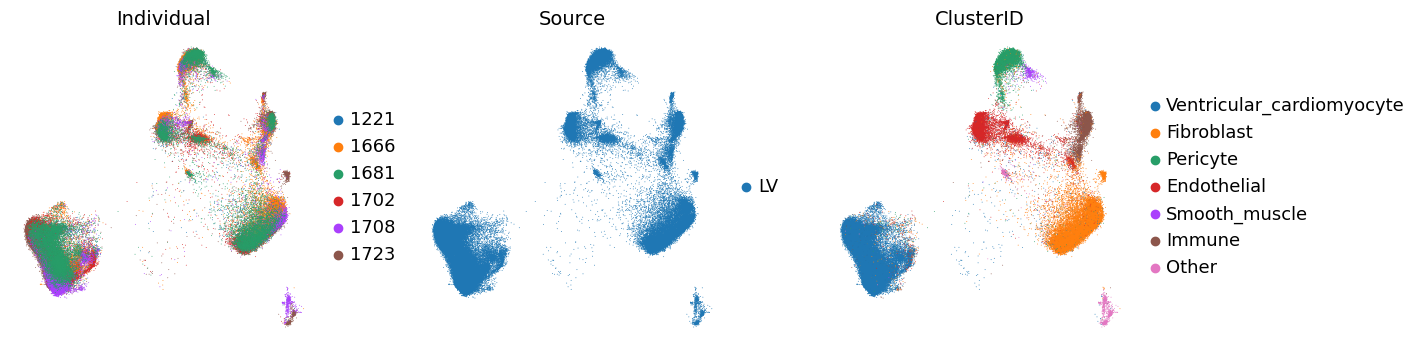

In [126]:
sc.pl.umap(adata, color=['Individual', 'Source', 'ClusterID'])
# interestingly, we lost one sample '1681'!

In [135]:
del adata.uns
del adata.obsm
del adata.layers

In [136]:
anndd[data_key] = adata
anndd[data_key]

AnnData object with n_obs × n_vars = 74364 × 33694
    obs: 'Individual', 'n_counts', 'n_genes', 'Experiment', 'Source', 'ClusterID'
    var: 'Accession'

In [ ]:
#########################################################################################################

In [147]:
# sort gene ids
# first try to use already assigned ids from Livitnukova and Tucker and map these to Wang
# keep the Livitnukova ids in case they are not matching - we don't check

id_map = {**anndd['Tucker'].var.to_dict('dict')['Accession'], **anndd['Litvinukova'].var.to_dict('dict')['Accession']}

In [168]:
anndd['Wang'].var['Accession'] = anndd['Wang'].var.index.map(id_map)
# but we still have 6954 unassigned ids...

In [191]:
# this was obtained earlier by combining all gene symbols
# R
# library(EnsDb.Hsapiens.v86) 
# genenames = read.table('/prj/LZ_PR2B_rewiring/public/joint_names.txt', check.names=FALSE)
# m <- mapIds(EnsDb.Hsapiens.v86,
#             keys=as.character(genenames$V1),
#             column="GENEID",
#             keytype="SYMBOL",
#             multiVals="first")
# m <- t(data.frame(as.list(m), check.names=FALSE))
# write.table(m,'/prj/LZ_PR2B_rewiring/public/EnsDb.Hsapiens.v86.csv', 
#             row.names=T, col.names=F,
#             quote=F, sep=",")

genes = pd.read_csv('/prj/LZ_PR2B_rewiring/public/EnsDb.Hsapiens.v86.csv', 
                    header=None, names=['Accession'], index_col=0)
genes = genes.to_dict('dict')['Accession']

unassigned = anndd['Wang'].var[anndd['Wang'].var['Accession'].isna()].copy()
unassigned['Accession'] = unassigned.index.map(genes)
# fill remaining with symbol - we're not annotating the remaining ~400 genes by hand...
unassigned.loc[unassigned.Accession.isna(), 'Accession'] = unassigned[unassigned.Accession.isna()].index.values
anndd['Wang'].var.loc[anndd['Wang'].var.Accession.isna(), 'Accession'] = unassigned.Accession.values

In [ ]:
#########################################################################################################

In [197]:
# finally, perform library-size normalization

target_sum = 1e6 # CPM

for data_key in ['Wang', 'Litvinukova', 'Tucker']:
    X_norm = sc.pp.normalize_total(anndd[data_key], 
                                   target_sum=target_sum, 
                                   exclude_highly_expressed=True,
                                   inplace=False)['X']
    anndd[data_key].layers['cpm'] = X_norm
    

In [209]:
# write to disk
for data_key in ['Wang', 'Litvinukova', 'Tucker']:
    anndd[data_key].write_loom(os.path.join(outputDir, f"{data_key}_scaden.loom"))


In [ ]:
#########################################################################################################

In [ ]:
# absl-py==0.12.0                                                                                                                                                             
# aiohttp==3.7.4.post0                                                                                                                                                        
# anndata==0.7.6
# annoy==1.17.0                                                                                                                                                     
# appdirs==1.4.4                                                                                                                                                              
# argon2-cffi==20.1.0                                                                                                                                                         
# async-generator==1.10                                                                                                                                                       
# async-timeout==3.0.1                                                                                                                                                        
# attrs==21.2.0                                                                                                                                                               
# backcall==0.2.0                                                                                                                                                             
# bbknn==1.4.1                                                                                                                                                                
# beautifulsoup4==4.9.3                                                                                                                                                       
# bioservices==1.7.11                                                                                                                                                         
# bleach==3.3.0                                                                                                                                                               
# cachetools==4.2.2                                                                                                                                                           
# certifi==2020.12.5                                                                                                                                                          
# cffi==1.14.5                                                                                                                                                                
# chardet==4.0.0                                                                                                                                                              
# click==8.0.0                                                                                                                                                                
# colorama==0.4.4                                                                                                                                                             
# colorlog==5.0.1                                                                                                                                                             
# commonmark==0.9.1                                                                                                                                                           
# cycler==0.10.0                                                                                                                                                              
# Cython==0.29.23                                                                                                                                                             
# decorator==4.4.2                                                                                                                                                            
# defusedxml==0.7.1                                                                                                                                                           
# easydev==0.11.1                                                                                                                                                             
# entrypoints==0.3                                                                                                                                                            
# et-xmlfile==1.1.0                                                                                                                                                           
# fsspec==2021.5.0                                                                                                                                                            
# future==0.18.2                                                                                                                                                              
# get-version==2.2                                                                                                                                                            
# gevent==21.1.2                                                                                                                                                              
# google-auth==1.30.0                                                                                                                                                         
# google-auth-oauthlib==0.4.4                                                                                                                                                 
# greenlet==1.1.0                                                                                                                                                             
# grequests==0.6.0                                                                                                                                                            
# grpcio==1.37.1                                                                                                                                                              
# gseapy==0.10.4                                                                                                                                                              
# h5py==3.2.1                                                                                                                                                                 
# idna==2.10 
# imageio==2.9.0                                                                                                                                                     
# ipykernel==5.5.4                                                                                                                                                            
# ipython==7.23.1                                                                                                                                                             
# ipython-genutils==0.2.0                                                                                                                                                     
# ipywidgets==7.6.3                                                                                                                                                           
# itsdangerous==2.0.1                                                                                                                                                         
# jedi==0.18.0                                                                                                                                                                
# Jinja2==3.0.0                                                                                                                                                               
# joblib==1.0.1                                                                                                                                                               
# jsonschema==3.2.0                                                                                                                                                           
# jupyter-client==6.1.12                                                                                                                                                      
# jupyter-core==4.7.1                                                                                                                                                         
# jupyterlab-pygments==0.1.2                                                                                                                                                  
# jupyterlab-widgets==1.0.0                                                                                                                                                   
# kiwisolver==1.3.1                                                                                                                                                           
# legacy-api-wrap==1.2                                                                                                                                                        
# leidenalg==0.8.4                                                                                                                                                            
# llvmlite==0.36.0                                                                                                                                                            
# loompy==3.0.6                                                                                                                                                               
# lxml==4.6.3                                                                                                                                                                 
# Markdown==3.3.4                                                                                                                                                             
# MarkupSafe==2.0.0                                                                                                                                                           
# matplotlib==3.4.2                                                                                                                                                           
# matplotlib-inline==0.1.2                                                                                                                                                    
# mistune==0.8.4                                                                                                                                                              
# multidict==5.1.0                                                                                                                                                            
# natsort==7.1.1                                                                                                                                                              
# nbclient==0.5.3                                                                                                                                                             
# nbconvert==6.0.7                                                                                                                                                            
# nbformat==5.1.3                                                                                                                                                             
# nest-asyncio==1.5.1                                                                                                                                                         
# networkx==2.5.1                                                                                                                                                             
# notebook==6.4.0                                                                                                                                                             
# numba==0.53.1                                                                                                                                                               
# numexpr==2.7.3                                                                                                                                                              
# numpy==1.20.3                                                                                                                                                               
# numpy-groupies==0.9.13                                                                                                                                                      
# oauthlib==3.1.0
# openpyxl==3.0.7                                                                                                                                                    
# opt-einsum==3.3.0                                                                                                                                                           
# packaging==20.9                                                                                                                                                             
# pandas==1.2.4                                                                                                                                                               
# pandocfilters==1.4.3                                                                                                                                                        
# parso==0.8.2                                                                                                                                                                
# patsy==0.5.1                                                                                                                                                                
# pexpect==4.8.0                                                                                                                                                              
# pickleshare==0.7.5
# Pillow==8.2.0
# prometheus-client==0.10.1
# prompt-toolkit==3.0.18
# protobuf==3.17.0
# ptyprocess==0.7.0
# pyasn1==0.4.8
# pyasn1-modules==0.2.8
# pycparser==2.20
# Pygments==2.9.0
# pynndescent==0.5.2
# pyparsing==2.4.7
# pyro-api==0.1.2
# pyro-ppl==1.6.0
# pyrsistent==0.17.3
# python-dateutil==2.8.1
# python-igraph==0.9.1
# pytorch-lightning==1.2.10
# pytz==2021.1
# PyWavelets==1.1.1
# PyYAML==5.3.1
# pyzmq==22.0.3
# requests==2.25.1
# requests-cache==0.6.3
# requests-oauthlib==1.3.0
# rich==10.2.1
# rsa==4.7.2
# scanpy==1.7.2
# scikit-image==0.18.1
# scikit-learn==0.24.2
# scipy==1.6.3
# scrublet==0.2.3
# scvi-tools==0.10.1
# seaborn==0.11.1
# Send2Trash==1.5.0
# sinfo==0.3.4
# six==1.16.0
# soupsieve==2.2.1
# statsmodels==0.12.2
# stdlib-list==0.8.0
# suds-jurko==0.6
# tables==3.6.1
# tensorboard==2.4.1
# tensorboard-plugin-wit==1.8.0
# terminado==0.10.0
# testpath==0.5.0
# texttable==1.6.3
# threadpoolctl==2.1.0
# tifffile==2021.4.8
# torch==1.8.1+cu111
# torchaudio==0.8.1
# torchmetrics==0.2.0
# torchvision==0.9.1+cu111
# tornado==6.1
# tqdm==4.60.0
# traitlets==5.0.5
# typing-extensions==3.10.0.0
# umap-learn==0.5.1
# url-normalize==1.4.3
# urllib3==1.26.4
# wcwidth==0.2.5
# webencodings==0.5.1
# Werkzeug==2.0.1
# widgetsnbextension==3.5.1
# wrapt==1.12.1
# xlrd==1.2.0
# xmltodict==0.12.0
# yarl==1.6.3
# zope.event==4.5.0
# zope.interface==5.4.0
